In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.metrics.pairwise import euclidean_distances
#Dunn’s Index

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import pandas as pd
from numpy import vstack
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
filename = './data/CbsPersist_20220420183220.log'
with open(filename, 'r') as f:
    text = f.readlines()
print (len(text))

168983


642 0


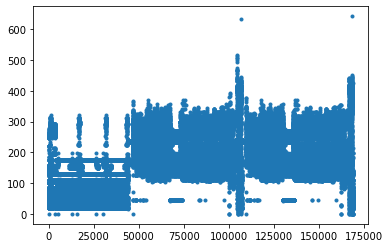

In [4]:
text = np.array(text)
logs = [t.split('  ')[-1].strip() for t in text]
logs = np.array(logs)
lengths = np.array([len(l) for l in logs])
print (max(lengths), min(lengths))
logs = logs[np.where(lengths > 10)]
text = text[np.where(lengths > 10)]
plt.plot(lengths, '.')
plt.show()

In [17]:
samples = [l.split() for l in logs]

In [85]:
max_words = 20000
maxlen = 400

# Tokenize values.
tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 25344 unique tokens.


In [87]:
data

array([[   0,    0,    0, ...,  175,  176,  171],
       [   0,    0,    0, ...,  256,  263, 6708],
       [   0,    0,    0, ...,   93,   68,  125],
       ...,
       [   0,    0,    0, ..., 1613, 8108, 8109],
       [   0,    0,    0, ...,  102,   58,  178],
       [   0,    0,    0, ...,   94,   68,  129]])

In [88]:
# Split data into training and test set. 
training_samples = int(len(samples) * 0.80)
test_samples = int(len(samples) * 0.20)

In [89]:
x = data[:training_samples]
x_test = data[training_samples: training_samples + test_samples]

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='./models/cbs_1.h5',
    monitor='val_loss',
    save_best_only=True
    )
]


In [91]:
# Create model.
input_dim = x.shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(100, activation='relu')(input)
encode = Dense(30, activation='relu')(encode)

decode = Dense(100, activation='relu')(encode)
decode = Dense(400, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 400)               40400     
Total params: 86,630
Trainable params: 86,630
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Train model.
history = autoencoder.fit(x, x,
        epochs=50,
        batch_size=32,
        callbacks=callbacks_list,
        validation_data=(x_test, x_test),
        shuffle=True
        )

Epoch 1/50
4223/4223 [==============================] - 8s 2ms/step - loss: 63088.8511 - accuracy: 0.0092 - val_loss: 102983.5156 - val_accuracy: 8.8805e-05
Epoch 2/50
4223/4223 [==============================] - 7s 2ms/step - loss: 62829.1370 - accuracy: 4.1583e-05 - val_loss: 102983.4766 - val_accuracy: 8.8805e-05
Epoch 3/50
4223/4223 [==============================] - 7s 2ms/step - loss: 63799.9523 - accuracy: 1.3628e-04 - val_loss: 102983.5703 - val_accuracy: 8.8805e-05
Epoch 4/50
4223/4223 [==============================] - 7s 2ms/step - loss: 62579.4123 - accuracy: 1.2272e-05 - val_loss: 102983.3281 - val_accuracy: 8.8805e-05
Epoch 5/50
4223/4223 [==============================] - 7s 2ms/step - loss: 62747.5263 - accuracy: 1.6737e-05 - val_loss: 102983.3203 - val_accuracy: 8.8805e-05
Epoch 6/50
4223/4223 [==============================] - 7s 2ms/step - loss: 63130.8912 - accuracy: 1.4353e-05 - val_loss: 102983.3203 - val_accuracy: 8.8805e-05
Epoch 7/50
4223/4223 [================

In [4]:
import tarfile


In [5]:
my_tar = tarfile.open('./data/Windows.tar.gz')

In [6]:
index = {i.name: i for i in my_tar.getmembers()}

print(index.keys())

dict_keys(['Windows.log'])


In [7]:
for tarinfo in my_tar:
    name = tarinfo.path.split('/')[-1]
    print (name)
    content= my_tar.extractfile(tarinfo.path).read(1024 * 10).decode("utf-8") 

Windows.log


In [8]:
print(content.split('\r')[33])


2016-09-28 04:30:31, Info                  CBS    Warning: Unrecognized packageExtended attribute.


In [6]:
def sklearn_tokenize(input_texts, vocab_size, ngram_range, mystopwords = [],  max_df = 1.0, min_df = 1):
    vectorizer = TfidfVectorizer(max_df=max_df, max_features=vocab_size, ngram_range = ngram_range,
                                     min_df=min_df,  norm='l2',
                                     use_idf=True, smooth_idf = False)
    X = vectorizer.fit_transform(input_texts)
#    return (X.todense(), vectorizer)
    return (X, vectorizer)

In [7]:
VOCAB_SIZE = 12000
top_grams = 1
tfidf_data, vector = sklearn_tokenize(logs, top_grams * VOCAB_SIZE, (1,top_grams), max_df = 0.5)
print(tfidf_data.shape)

(168910, 11657)


In [37]:
vector.vocabulary_

{'ti': 11387,
 'initializing': 10299,
 'trusted': 11417,
 'installer': 10303,
 'last': 10388,
 'boot': 8158,
 'time': 11395,
 '2022': 2378,
 '04': 185,
 '17': 1596,
 '21': 2406,
 '11': 751,
 '29': 2736,
 '500': 4682,
 'starting': 11312,
 'trustedinstaller': 11418,
 'initialization': 10297,
 'lock': 10418,
 'new': 10576,
 'added': 7133,
 'ccbspublicsessionclassfactory': 8350,
 'level': 10401,
 '30': 2866,
 'total': 11407,
 'winlogonnotifylock': 11607,
 'ending': 9835,
 'the': 11384,
 'main': 10439,
 'loop': 10424,
 'service': 11218,
 'starts': 11313,
 'successfully': 11332,
 'no': 10590,
 'startup': 11314,
 'processing': 11056,
 'required': 11137,
 'was': 11556,
 'not': 10599,
 'set': 11235,
 'as': 7906,
 'autostart': 7923,
 'thread': 11386,
 'terminated': 11370,
 'normally': 10598,
 'completes': 8458,
 'release': 11112,
 'wu': 11638,
 'creates': 8511,
 'appid': 7879,
 'ccmexec': 8358,
 'updateid': 11459,
 'bc52fa8d': 8092,
 '17e0': 1631,
 '4feb': 4679,
 'a7d5': 7044,
 '8c0b31636aea': 6

In [21]:
n_components = 10

In [22]:
%%time
kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)

Wall time: 3min 56s


In [23]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

<BarContainer object of 10 artists>

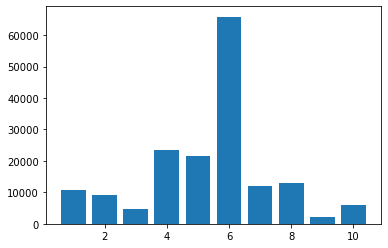

In [38]:
plt.bar(np.linspace(1,10, 10), np.histogram(kmeans.labels_, 10)[0])

In [39]:
silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000)

0.15013622958041486

In [40]:
%%time
sample_silhouette_values = silhouette_samples(tfidf_data,  kmeans.labels_)

Wall time: 10min 2s


In [41]:
sample_silhouette_values[:10]

array([ 0.01059771, -0.00152106,  0.02742762,  0.58881198,  0.58881198,
        0.57685548,  0.02742115,  0.02931999,  0.01707552,  0.01132561])

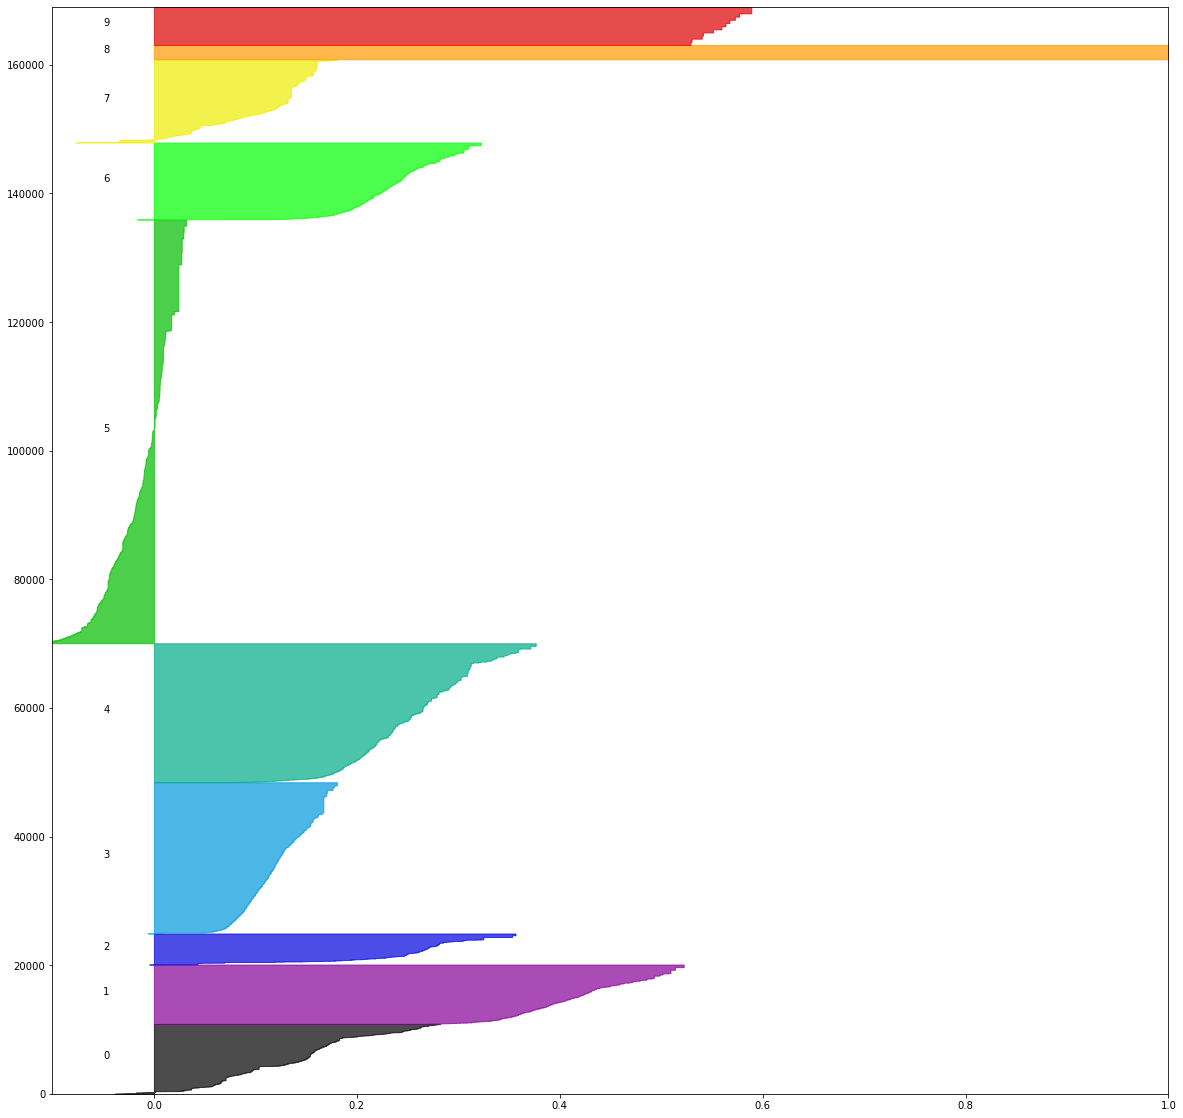

In [44]:
display_silhouette(sample_silhouette_values, kmeans.labels_, n_components, tfidf_data.shape[0])

In [48]:
for i in range(n_components):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    print (i, np.mean(ith_cluster_silhouette_values), sum(ith_cluster_silhouette_values < 0)/len(ith_cluster_silhouette_values))

0 0.13668850156001572 0.025903392330383482
1 0.4250510499868783 0.0
2 0.2533471510613456 0.0004154549231408392
3 0.12530512613822334 0.001786929884275017
4 0.2586036829296648 0.0
5 -0.008332386705539822 0.5053585524318417
6 0.2414962916001135 0.0008373105584861425
7 0.10680872347705636 0.03914590747330961
8 1.0 0.0
9 0.559534630363136 0.0


In [56]:
logs[kmeans.labels_ == 6]

array(['Appl: detect Parent, Package: Package_1_for_KB5012117~31bf3856ad364e35~amd64~~10.0.4494.3, Parent: Microsoft-Windows-NetFx3-OC-Package~31bf3856ad364e35~amd64~~10.0.19041.1, Disposition = Staged, VersionComp: EQ, BuildComp: EQ, RevisionComp: GE, Exist: present',
       'Appl: detect Parent, Package: Package_1_for_KB5012117~31bf3856ad364e35~amd64~~10.0.4494.3, Parent: Microsoft-Windows-NetFx3-OC-Package~31bf3856ad364e35~amd64~~10.0.19041.1, Disposition = Staged, VersionComp: EQ, BuildComp: EQ, RevisionComp: GE, Exist: present',
       'Appl: detect Parent, Package: Package_2_for_KB5012117~31bf3856ad364e35~amd64~~10.0.4494.3, Parent: Microsoft-Windows-NetFx3-OC-Package~31bf3856ad364e35~amd64~~10.0.19041.1, Disposition = Staged, VersionComp: EQ, BuildComp: EQ, RevisionComp: GE, Exist: present',
       ...,
       'Appl: detect Parent, Package: Microsoft-Windows-MediaPlayer-Payload-Package~31bf3856ad364e35~amd64~en-US~10.0.19041.1, Parent: Microsoft-Windows-MediaPlayer-Payload-Packa

10 0.1484681847048609
0 0.13668850156001572 0.025903392330383482
1 0.4250510499868783 0.0
2 0.2533471510613456 0.0004154549231408392
3 0.12530512613822334 0.001786929884275017
4 0.2586036829296648 0.0
5 -0.008332386705539822 0.5053585524318417
6 0.2414962916001135 0.0008373105584861425
7 0.10680872347705636 0.03914590747330961
8 1.0 0.0
9 0.559534630363136 0.0


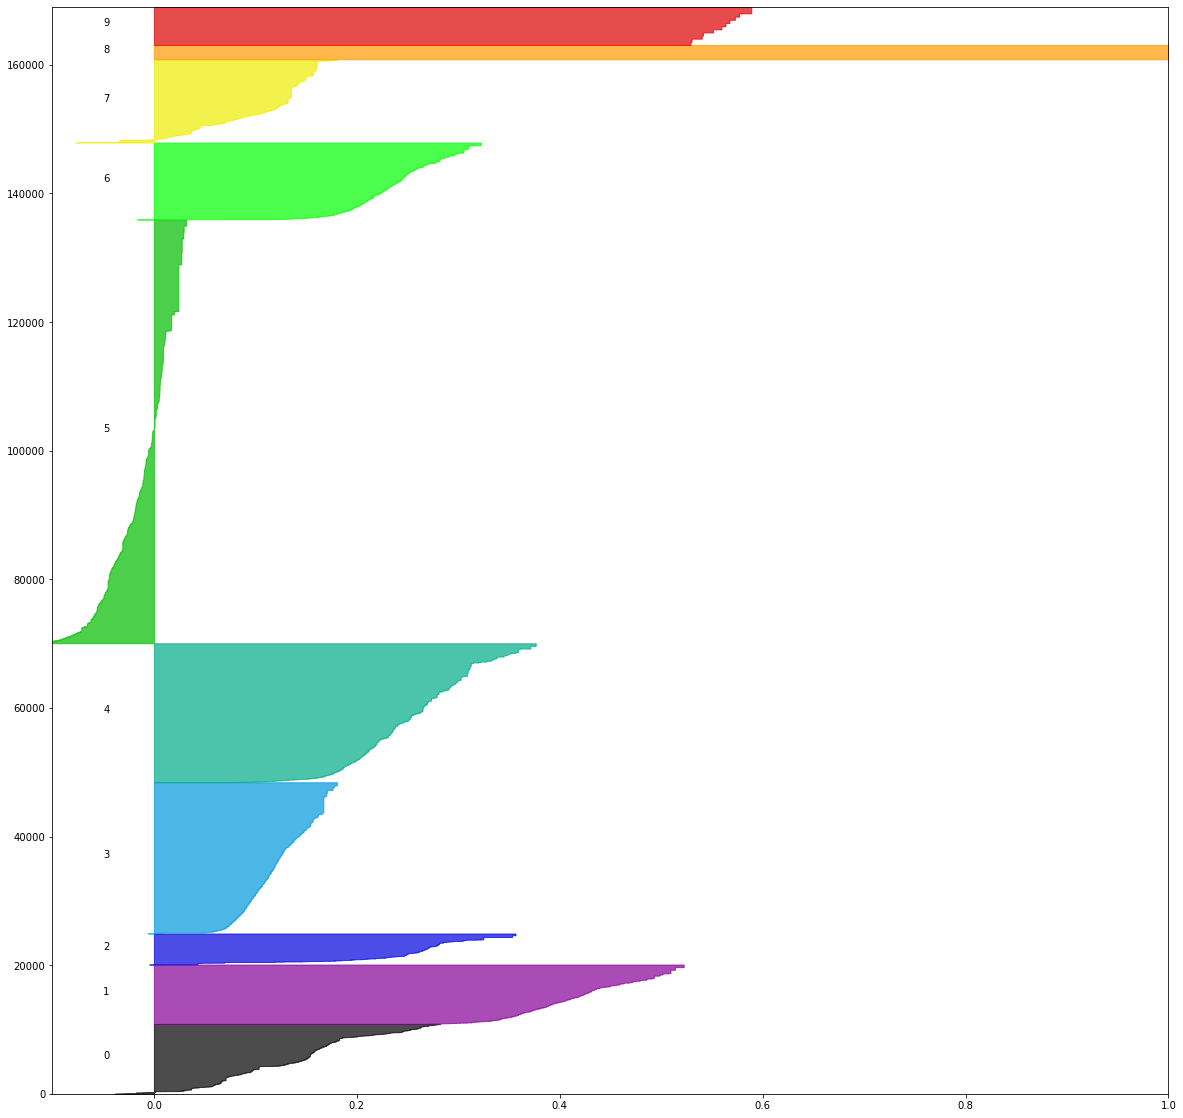

20 0.1951170757221073
0 0.16292694964928991 0.00035001750087504374
1 1.0 0.0
2 0.4208792339739453 0.0
3 0.5564728866255304 0.0
4 0.25610058691614224 0.0
5 -0.015198132992840542 0.6606054065720607
6 0.04459813227519333 0.17261765119879885
7 0.27589346086529554 0.0
8 0.08228011227689272 0.16546762589928057
9 0.1837804217365304 0.009570522789807393
10 0.1303271594683562 0.002108370229812355
11 0.08639287107456262 0.05481301471580937
12 0.1733949331228695 0.0
13 0.23988903704332573 0.002007192439575144
14 0.42731378591073804 0.0
15 0.13440780145280734 0.0
16 1.0 0.0
17 0.3134147301202406 0.0
18 0.23261467662080004 0.0
19 0.2777432627676458 0.003933136676499509


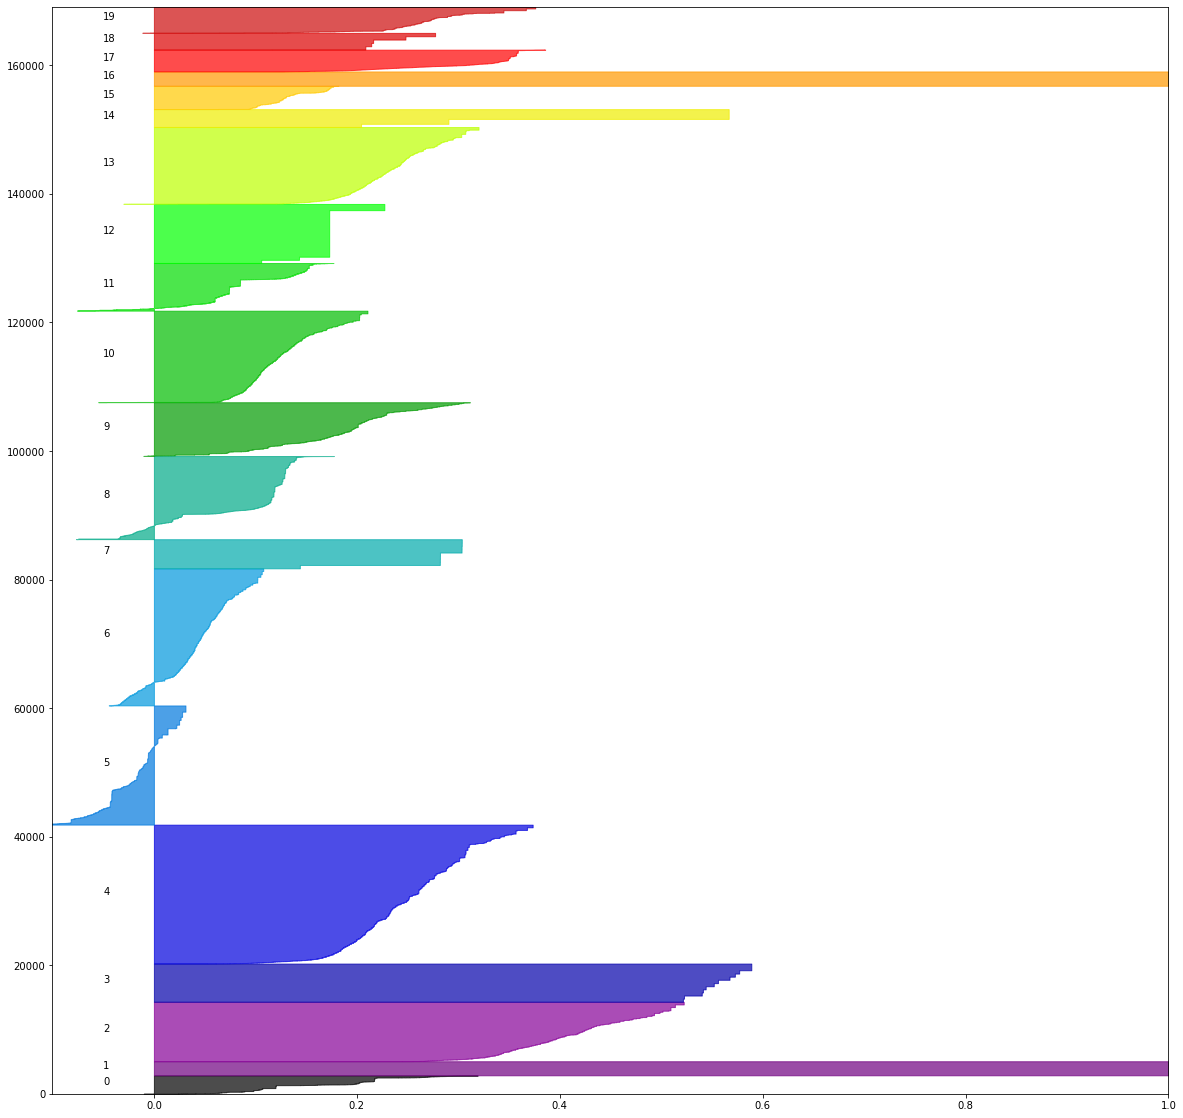

30 0.22074245905776824
0 0.2558875252960568 0.0
1 0.26937539263473553 0.0004997501249375312
2 1.0 0.0
3 0.18036703430740586 0.004424778761061947
4 0.12384709154614004 0.008316301360208613
5 0.13938217886386192 0.014302741358760428
6 0.19543000206598807 0.009467455621301775
7 0.17160687225251153 0.0
8 0.5569805453672401 0.0
9 0.17586957547674933 0.0
10 0.4488199895543304 0.0
11 0.42115896431042127 0.0
12 0.3483479836912302 0.0
13 0.1359511222786377 0.015558436747545841
14 0.5601206180408261 0.0
15 0.0924707382546765 0.029696394686907022
16 0.5284479251109063 0.0
17 0.002504204305767388 0.4808193227563344
18 0.1339449557960758 0.0
19 0.3013972549489284 0.0
20 0.04201379921202941 0.16736217878321985
21 0.15632884724568852 0.0
22 0.16657358184526955 0.0
23 0.13024099515208215 0.039711191335740074
24 1.0 0.0
25 0.21244368591251997 0.0020127474002012745
26 0.1176395605912836 0.003069367710251688
27 1.0 0.0
28 -0.017398868929801005 0.7645682190498478
29 0.09960775213018996 0.00144624779045476

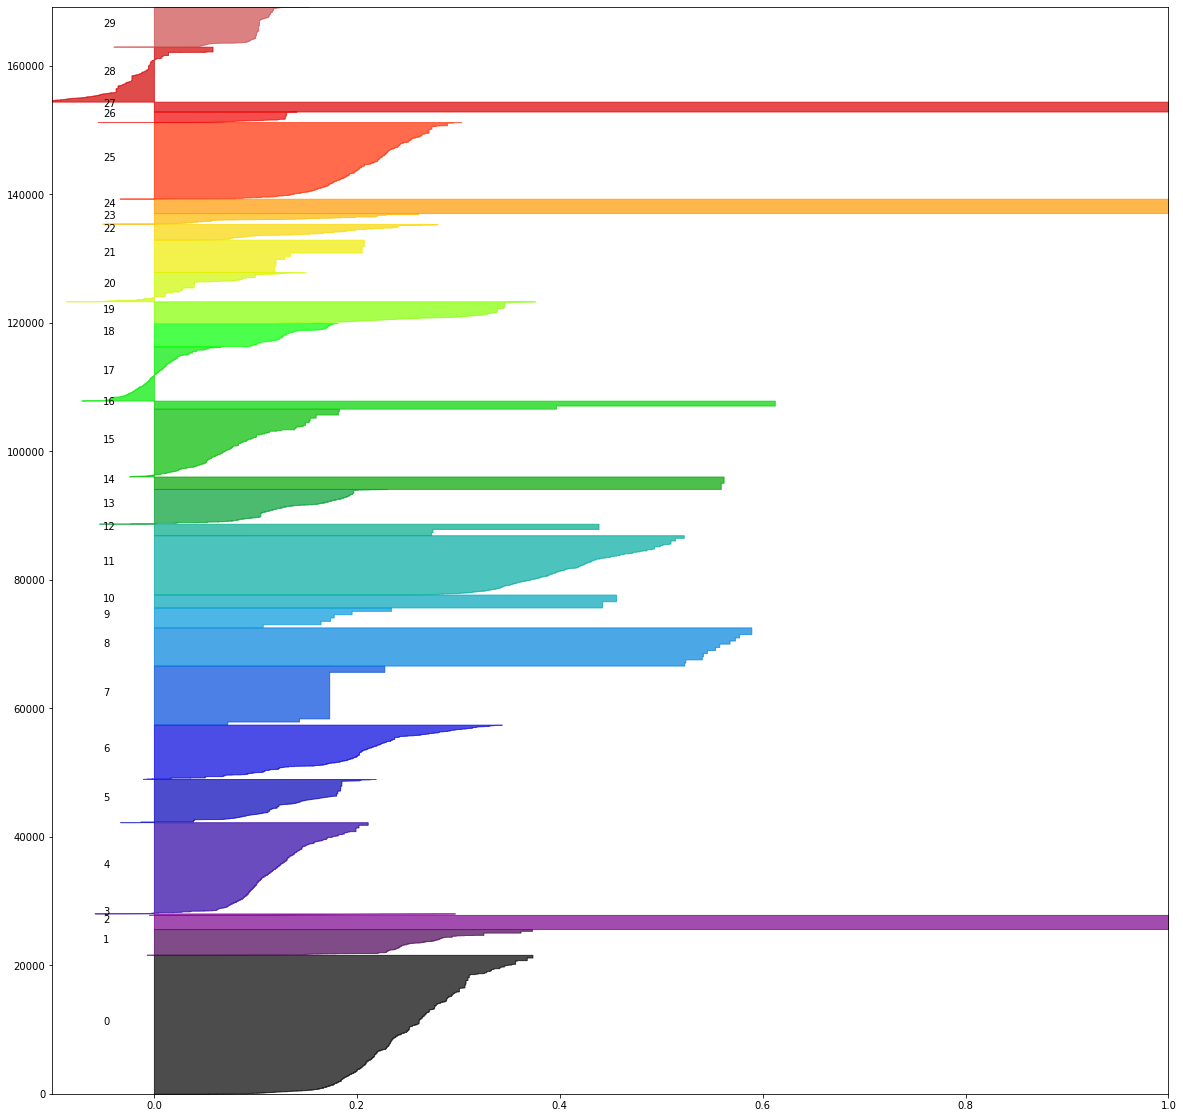

40 0.2237330924985031
0 0.27760645510166354 0.003940886699507389
1 1.0 0.0
2 0.12355885475415299 0.00035001750087504374
3 0.2551721363613417 0.0
4 0.5528590178146404 0.0
5 0.21041458967461402 0.0
6 0.009810386803921538 0.45563995986813816
7 1.0 0.0
8 0.42077930569836147 0.0
9 0.4428502436582206 0.0
10 0.15567975715099902 0.0
11 0.18342978251880546 0.009570522789807393
12 0.09621526627092628 0.018243109260360896
13 0.6483977863972754 0.0
14 0.6863956707931682 0.0
15 0.5591016748462904 0.0
16 -0.03410601438624273 0.7629179331306991
17 0.064724280156607 0.01684717208182912
18 0.1067189210542645 0.0
19 0.3061025392536556 0.0
20 0.13147663563235357 0.0
21 -0.012773229761506076 0.5450762829403606
22 1.0 0.0
23 0.11933096623501564 0.0
24 0.25024512590819625 0.0
25 0.5920589757679989 0.0
26 1.0 0.0
27 0.21264179116935905 0.0
28 0.05662123066463838 0.0
29 0.1694131174445348 0.0
30 0.5652603124912805 0.0
31 0.06677744756795326 0.045369504209541625
32 0.20666393502959576 0.0
33 0.5985594435554786

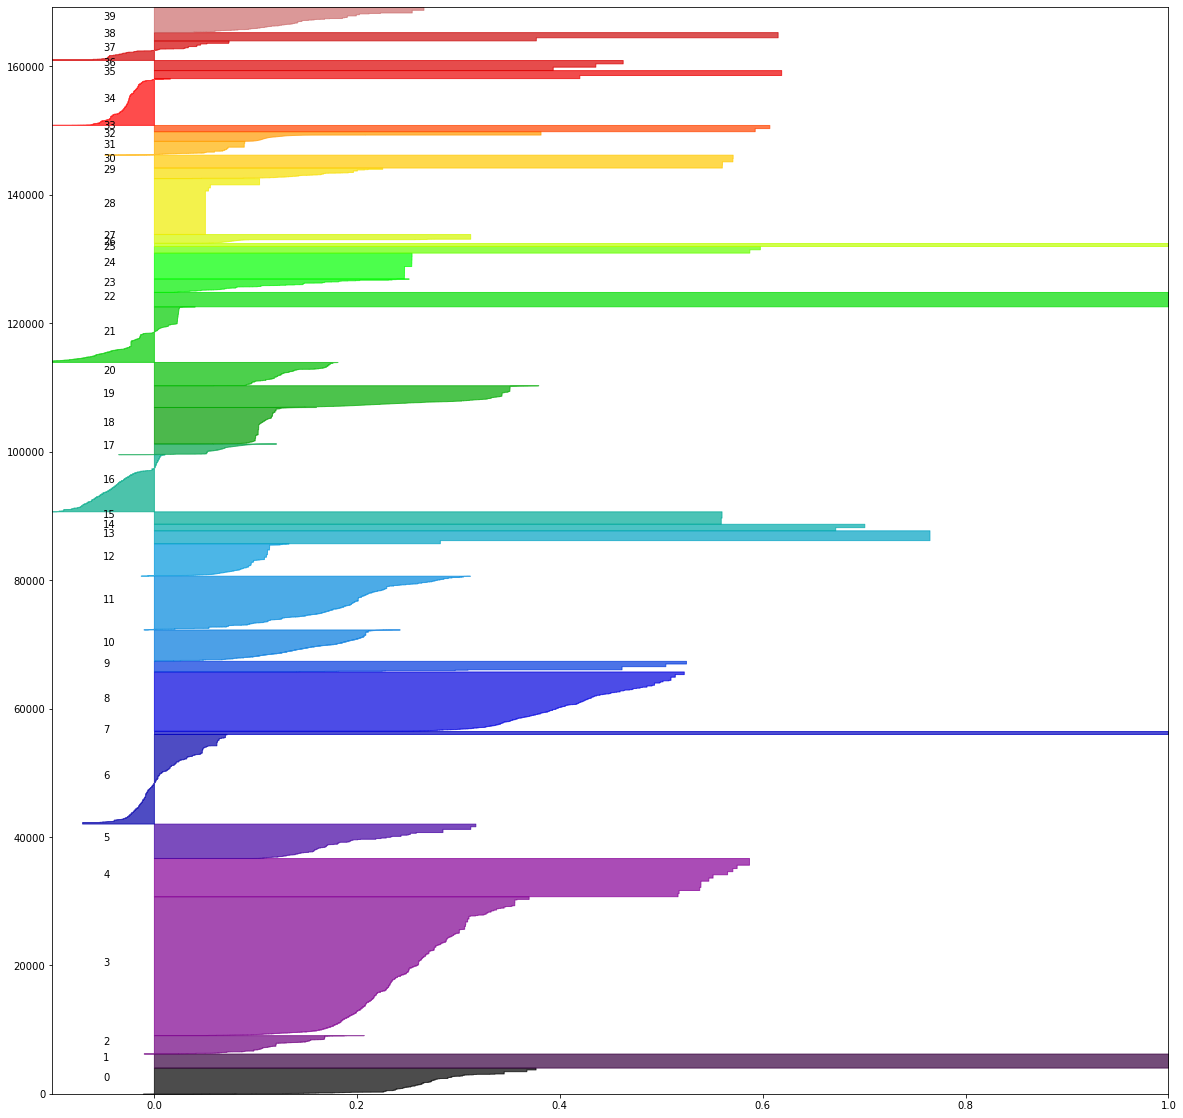

50 0.19459534586304397
0 1.0 0.0
1 0.6047221634278587 0.0
2 0.06341081730315547 0.13730929264909847
3 0.11495293976397271 0.000925925925925926
4 -0.01777041335625596 0.7607278241091736
5 0.1800981406627779 0.0
6 0.5464037053004333 0.0
7 -0.022815445287922193 0.9327649991957536
8 0.15997456204962504 0.0003497726477789437
9 0.13667388954395301 0.0061570035915854285
10 0.29999461748505607 0.0
11 0.020944951247725708 0.40813953488372096
12 0.09985446050579097 0.0
13 0.39273819866011445 0.0
14 0.1797152713419706 0.01637567730282962
15 0.6483918582339508 0.0
16 0.557427150910447 0.0
17 0.5652439483011666 0.0
18 0.5868173874078783 0.0
19 1.0 0.0
20 -0.03125020126313167 1.0
21 0.00020823701147546268 0.41993622625814503
22 0.275883184415365 0.0
23 0.1324754768273606 0.0
24 0.525468043885791 0.0
25 1.0 0.0
26 1.0 0.0
27 0.36118412108150794 0.0
28 0.17172626046361503 0.0
29 0.12455367266035286 0.01669150521609538
30 0.06034910139820318 0.0
31 0.186690912209455 0.0
32 0.13458512159344488 0.0
33 0.

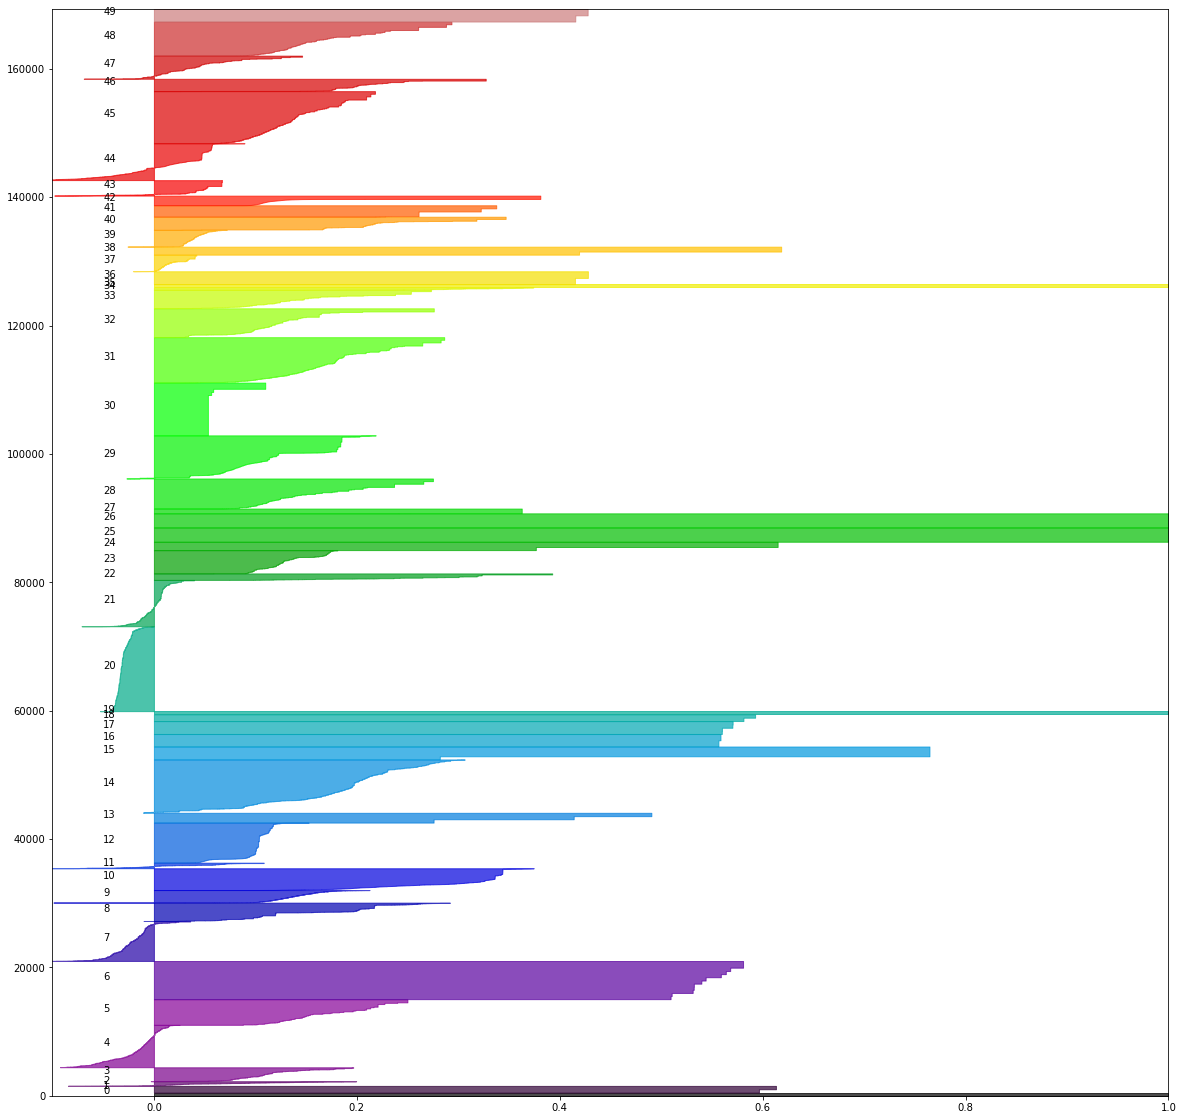

60 0.20854713743447598
0 0.1575368328360796 0.0
1 0.3261366949912541 0.0
2 0.21227302887225763 0.0
3 0.07334153179769078 0.0
4 0.20948986942820558 0.0
5 -0.03366082646366182 0.9763981528989225
6 0.31313514838957857 0.0
7 0.42160807858968724 0.0
8 1.0 0.0
9 1.0 0.0
10 1.0 0.0
11 0.4086266444241187 0.0
12 0.04912404022038178 0.042774883465862355
13 0.5652439483011666 0.0
14 0.05899912951057819 0.002080624187256177
15 1.0 0.0
16 0.10257462705791126 0.0
17 0.44566388379693916 0.0
18 1.0 0.0
19 0.1270429114269274 0.0
20 0.18048065690691573 0.0
21 1.0 0.0
22 0.147779124203748 0.0
23 0.1402165106059787 0.0
24 0.05872854187360279 0.030255839822024472
25 0.07446068673051562 0.0
26 0.15237574720148148 0.009103641456582634
27 1.0 0.0
28 0.42996035958746437 0.0
29 0.29665065032866544 0.0017678255745433118
30 1.0 0.0
31 1.0 0.0
32 -0.034815682176352634 0.7725375155139343
33 0.4216328424248011 0.0
34 0.17127360382345538 0.0
35 0.27738221814429104 0.0
36 1.0 0.0
37 0.03808693609487677 0.2166531932093

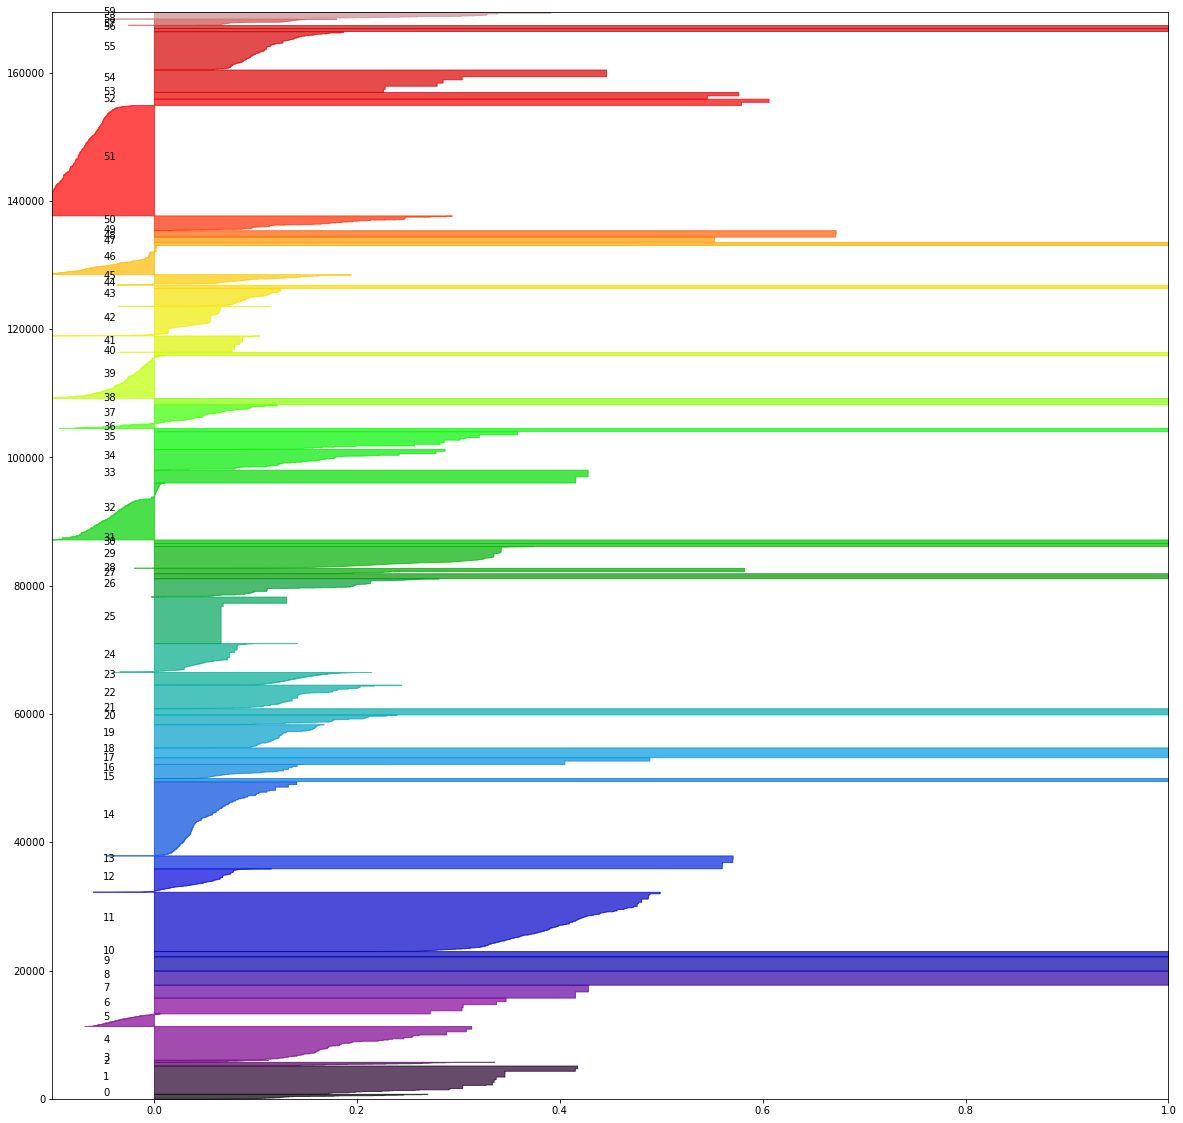

70 0.22043672574456386
0 0.15235875048456338 0.0003489183531053733
1 0.10220579066884833 0.03137902559867878
2 -0.000949818258346728 0.4488925574356858
3 0.08800267077832388 0.04043126684636118
4 0.20462677517768402 0.0
5 0.08312960886478166 0.0
6 0.2403434342692265 0.0
7 0.1206179516809982 0.030508474576271188
8 -0.014466936229135372 0.8971087504106888
9 1.0 0.0
10 1.0 0.0
11 0.12447275604815197 0.0
12 0.18459703590985144 0.010890211472711155
13 0.5671541406467773 0.0
14 0.28670811243073646 0.0
15 0.17587149644164418 0.0
16 1.0 0.0
17 0.14079635988275666 0.0
18 0.1826089523800216 0.0
19 0.6029406576433459 0.0
20 0.008826970766313664 0.3580629770992366
21 1.0 0.0
22 0.1264100782281726 0.0
23 1.0 0.0
24 0.36104603508309935 0.0
25 0.23025358734338366 0.0
26 -0.06119618730558919 0.9851205746536685
27 1.0 0.0
28 0.414321752280652 0.0
29 1.0 0.0
30 0.18034973447895583 0.0
31 0.1724540476202936 0.0
32 0.15725129220046447 0.0
33 0.4294654800907854 0.0
34 1.0 0.0
35 0.5236502727528765 0.0
36 0

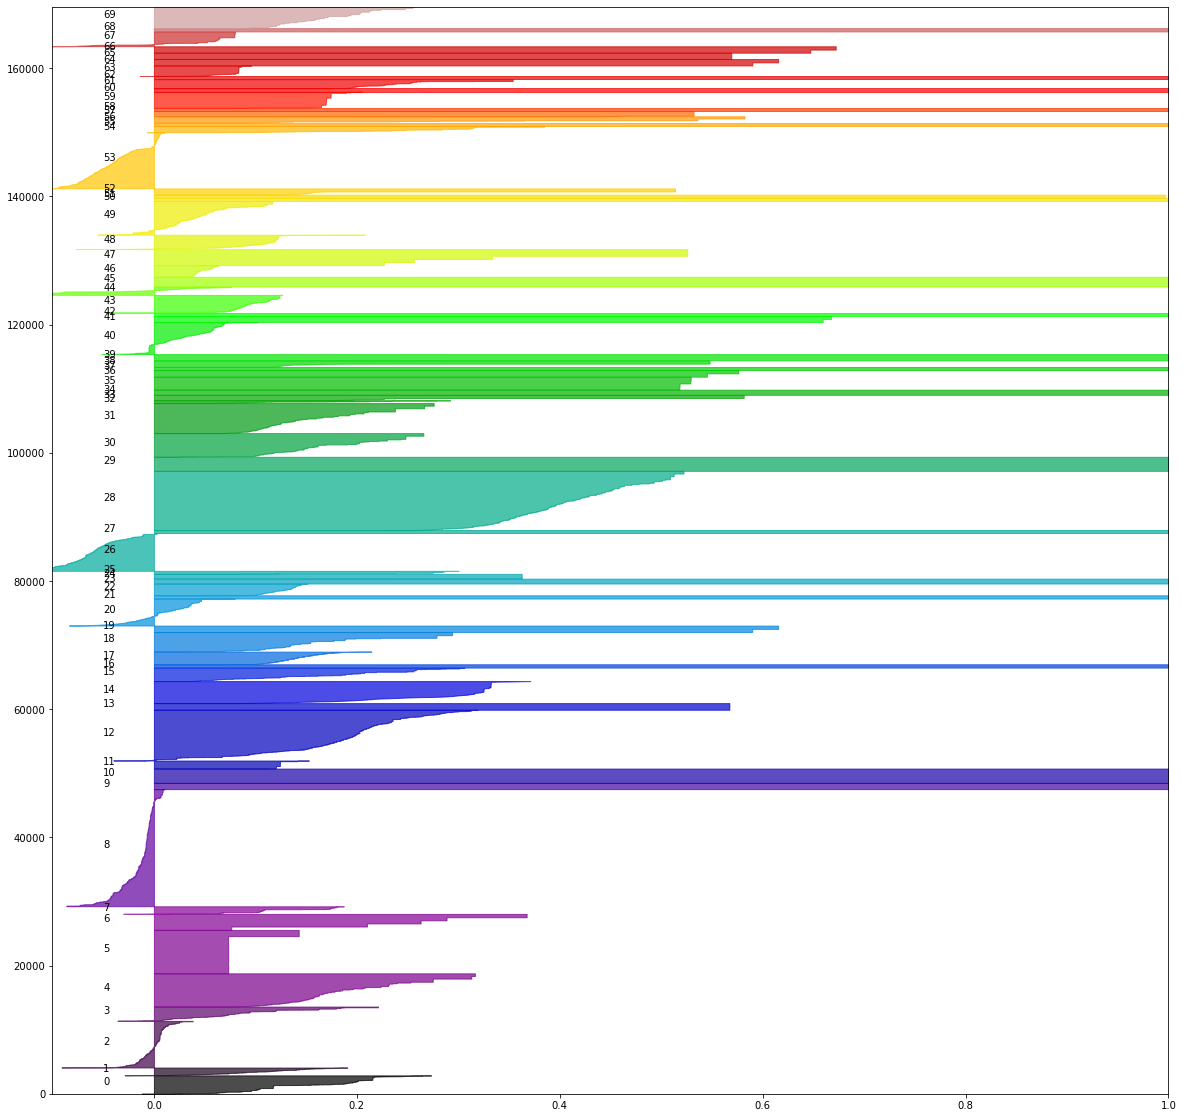

80 0.22753197706450792
0 0.15267098123574332 0.00035001750087504374
1 0.09664671699858329 0.0027675276752767526
2 -0.004656421728734769 0.5616675315689327
3 0.09647661793649782 0.04816285998013903
4 0.19625667974231673 0.0
5 0.12195140467287242 0.0
6 0.2403434342692265 0.0
7 0.1618453523296028 0.021739130434782608
8 -0.046056106757341266 1.0
9 1.0 0.0
10 1.0 0.0
11 0.12441682769835978 0.0
12 0.18000653123807703 0.046612882571391984
13 0.5671541406467773 0.0
14 0.29273647732719243 0.0
15 0.16223478458339172 0.006648936170212766
16 1.0 0.0
17 -0.0024355116827857173 0.6343126967471143
18 0.1548503754329787 0.022688791059939047
19 0.6029406576433459 0.0
20 0.008771445533684592 0.3575178997613365
21 1.0 0.0
22 0.1311152152670081 0.0
23 1.0 0.0
24 0.36104603508309935 0.0
25 0.22378893865386412 0.0
26 -0.03284843069520224 0.8801753531417438
27 1.0 0.0
28 0.4098600405580567 0.0
29 1.0 0.0
30 0.15183959377275794 0.0
31 0.14843222171325157 0.0
32 0.15419741751283902 0.018604651162790697
33 0.429

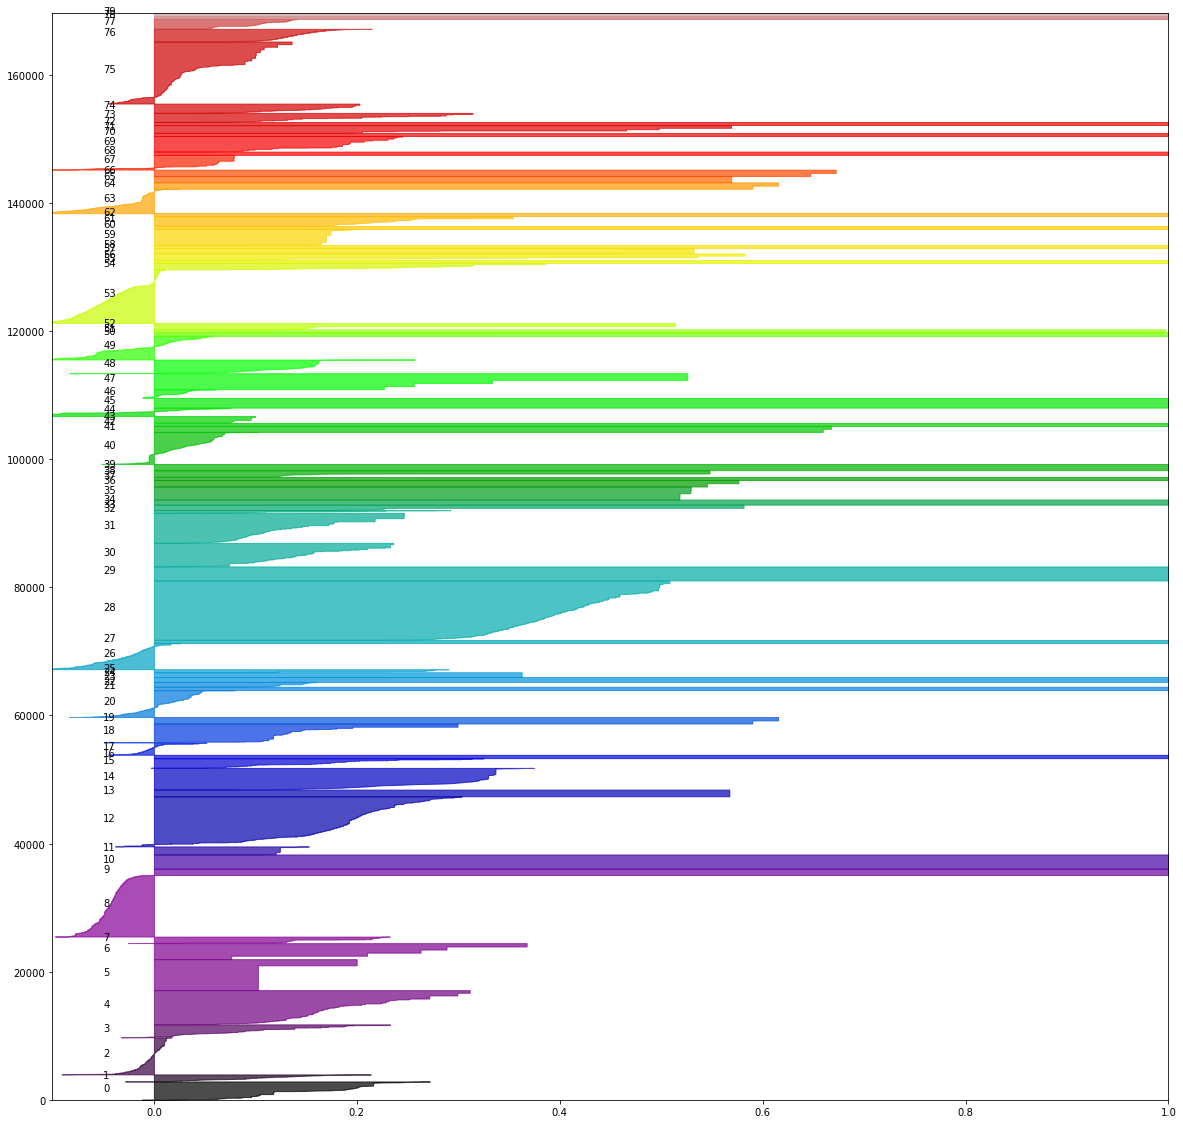

90 0.2212093547257103
0 0.14967064870846797 0.0003497726477789437
1 0.1150627831014535 0.018108651911468814
2 -0.005961900778508607 0.618629476584022
3 0.08542530513763245 0.04397233201581028
4 0.4338031499499924 0.0
5 0.15853206700550396 0.0
6 0.2403434342692265 0.0
7 0.1417572634923318 0.0
8 -0.04600244285066778 1.0
9 1.0 0.0
10 1.0 0.0
11 0.1136467472085395 0.0
12 0.08030786147480842 0.0005571806658308956
13 0.5671541406467773 0.0
14 0.2897974802301394 0.0
15 0.2183519959566072 0.0
16 1.0 0.0
17 0.0004723529608796661 0.5177548682703322
18 0.1449595014743092 0.0
19 0.6029406576433459 0.0
20 0.008771445533684592 0.3575178997613365
21 1.0 0.0
22 0.1311152152670081 0.0
23 1.0 0.0
24 0.36104603508309935 0.0
25 0.2228291660310535 0.0
26 -0.03370041309555099 0.8994622398877719
27 1.0 0.0
28 0.40643786663546644 0.0
29 1.0 0.0
30 0.0715495270737818 0.016214427531436135
31 0.1463188294489925 0.0025662959794696323
32 0.13163217816193568 0.030232558139534883
33 0.42869538363105675 0.0
34 1.0 0.

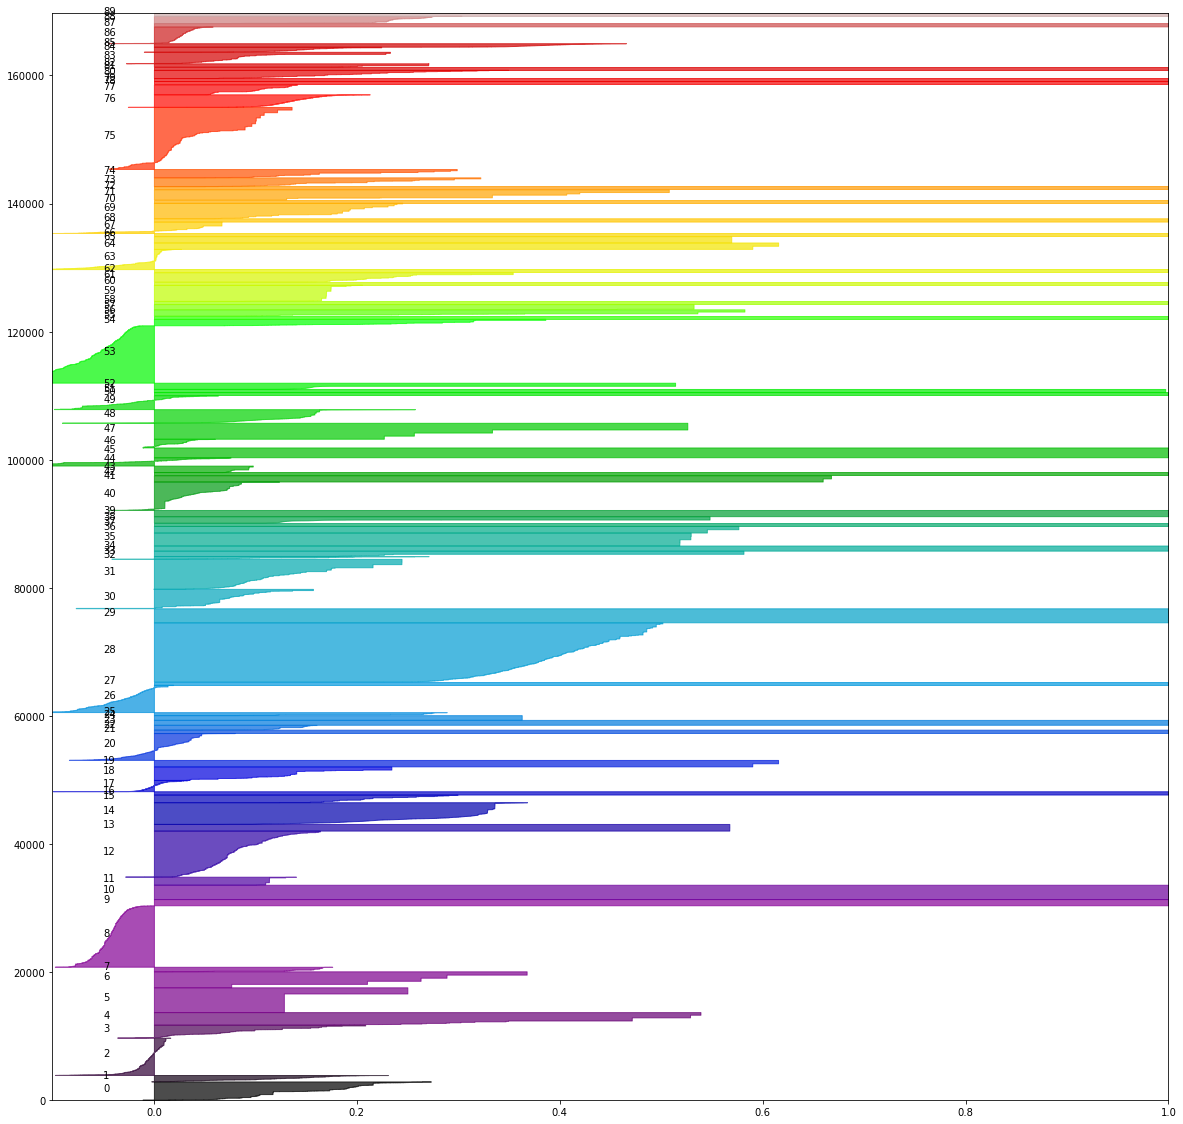

In [57]:
for n_components in range(10,100,10):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000))
    sample_silhouette_values = silhouette_samples(tfidf_data,  kmeans.labels_)
    for i in range(n_components):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        print (i, np.mean(ith_cluster_silhouette_values), sum(ith_cluster_silhouette_values < 0)/len(ith_cluster_silhouette_values))    
    display_silhouette(sample_silhouette_values, kmeans.labels_, n_components, tfidf_data.shape[0])

In [62]:
outliers = {}
for n_components in range(10,100,10):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    sample_silhouette_values = silhouette_samples(tfidf_data,  kmeans.labels_)
    outlier = np.where(sample_silhouette_values < 0)[0]
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000),
           np.mean(sample_silhouette_values), len(outlier))
    outliers[n_components] = outlier
   
    

10 0.14852170488541916 0.1446143972215479 34132
20 0.19887110976637548 0.1985986660163696 18618
30 0.22418713855667574 0.22226319015945772 12155
40 0.22914967100841147 0.21759949108309168 26867
50 0.20755632102034866 0.18839169388101804 30533
60 0.19772916766754803 0.2056131892799482 37450
70 0.22193820942535533 0.22595812014680122 37379
80 0.2354236846963675 0.23809453066370811 35615
90 0.22792952891284535 0.24239834696224358 34065


In [63]:
for i in range(10,100,10):
    for j in range(i+10,100,10):
        print (len(outliers[i]), len(outliers[j]), len(set(outliers[i]).intersection(set(outliers[j]))))

34132 18618 10053
34132 12155 4578
34132 26867 9874
34132 30533 7716
34132 37450 10004
34132 37379 8502
34132 35615 11252
34132 34065 11692
18618 12155 7887
18618 26867 7111
18618 30533 4620
18618 37450 5516
18618 37379 4784
18618 35615 7360
18618 34065 4905
12155 26867 6317
12155 30533 5044
12155 37450 5036
12155 37379 5110
12155 35615 4963
12155 34065 3980
26867 30533 14658
26867 37450 13018
26867 37379 14812
26867 35615 14853
26867 34065 13839
30533 37450 22677
30533 37379 24279
30533 35615 19746
30533 34065 19301
37450 37379 25671
37450 35615 22793
37450 34065 21583
37379 35615 27753
37379 34065 25084
35615 34065 29265


In [67]:
start = 10
end = 100
step = 10
intersection = set(outliers[start])
for i in range(start+step,end,step):
    intersection = intersection.intersection(set(outliers[i]))
len(intersection)

905

In [57]:
df_log = pd.DataFrame({'text':logs, 'label':kmeans.labels_})
df_log.to_csv('./results/kmeans1.csv', index=False)

In [62]:
for n_components in range(6,16,2):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000))

6 0.11028689095931617
8 0.12453397889257192
10 0.1462168715642909
12 0.1703680881584502
14 0.1727502693566659


In [65]:
for n_components in range(18,26,2):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000))

18 0.159707442275628
20 0.1887259858028319
22 0.1953427387164747
24 0.19989725088601545


In [66]:
for n_components in range(28,36,2):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000))

28 0.21250794787253038
30 0.21822442721931515
32 0.17138165501082064
34 0.21234036596658212


In [67]:
for n_components in range(28,36,2):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=10000))

28 0.21801761402463996
30 0.2258287936373111
32 0.17624091636839587
34 0.21243584465699633


In [81]:
for n_components in range(30,100,10):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000))

30 0.21831514848767145
40 0.2085817997015683
50 0.23263597228455243
60 0.20087955480801936
70 0.21292020763064606
80 0.2262654553747486
90 0.24949608727307515


In [82]:
%%time
sample_silhouette_values = silhouette_samples(tfidf_data,  kmeans.labels_)

Wall time: 9min 30s


In [55]:
def display_silhouette(silhouette_values, kmeans_labels, n_clusters, data_size):
    plt.figure(figsize = (20,20))
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, data_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_values[kmeans_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
            # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.show()

In [84]:
for n_components in range(200,1000,100):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000))

200 0.30857017145678406
300 0.2995193651843563
400 0.34354799774624645
500 0.3242682433111065
600 0.3926438100493489
700 0.3776967813521864
800 0.3748212907104952
900 0.37154711989309847


In [ ]:
%%time
for n_components in range(1100,2000,100):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000))

1100 0.3654924178332371
1200 0.3835580801298137
1300 0.399558020119381
1400 0.3839918327143446
1500 0.36865268561852316
1600 0.3915844351090179
1700 0.4102084013361727
1800 0.38285049100786195


In [77]:
sample_silhouette_values

array([ 0.04867409, -0.00675054,  0.30146466, ...,  0.00391736,
        0.13957368,  0.45125578])

In [8]:
start = 4000
end = 5000
step = 100

In [9]:
outliers1 = {}
for n_components in range(start,end,step):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(tfidf_data)
    sample_silhouette_values = silhouette_samples(tfidf_data,  kmeans.labels_)
    outlier = np.where(sample_silhouette_values < 0)[0]
    print (n_components, silhouette_score(tfidf_data, kmeans.labels_, sample_size=1000),
           np.mean(sample_silhouette_values), len(outlier))
    outliers1[n_components] = outlier

4000 0.37898582910734707 0.6745524699361248 4675
4100 0.42009108160920383 0.6771659486257346 4591
4200 0.379328873166518 0.6797643178989929 4520
4300 0.38793384493387806 0.6827596290742244 4432
4400 0.38015264933329584 0.6852733539396437 4360
4500 0.36553608218363715 0.6882168896209079 4539
4600 0.38966004857680453 0.6908079089648334 4452
4700 0.3541084626645752 0.693758436872294 4382
4800 0.3925676487516607 0.6970406061814389 3793
4900 0.38855228542325254 0.6997395327865464 3672


In [10]:
intersection1 = set(outliers1[start])
for i in range(start+step,end,step):
    intersection1 = intersection1.intersection(set(outliers1[i]))
len(intersection1)

1134

In [11]:
intersection1 = np.array(list(intersection1))
text_outliers1 = text[intersection1]

In [12]:
text_outliers1

array(['2022-04-18 21:24:23, Info                  CSI    00000001@2022/4/19:01:24:23.832 WcpInitialize: wcp.dll version 10.0.19041.1613 (WinBuild.160101.0800)\n',
       "2022-04-20 14:14:17, Info                  CSI    56ad364e35~amd64~~10.0.19041.1415.FD53F48BAA96F82D9A99B70947E4126646A4F7C9110F17EBE1B3CD129203F94D' ncdata: [l:0]'')\n",
       '2022-04-20 01:54:12, Info                  CBS    Read out cached applicability from TiLight for package: Package_for_KB4598481~31bf3856ad364e35~amd64~~19041.740.1.1, ApplicableState: 0, CurrentState:0\n',
       ...,
       '2022-04-20 14:25:47, Info                  CBS    Appl: Evaluating package applicability for package Package_for_KB4589212~31bf3856ad364e35~amd64~~10.0.2.4, applicable state: Installed\n',
       '2022-04-20 14:25:48, Info                  CBS    Plan: Package: HyperV-Compute-System-VmDirect-merged-Package~31bf3856ad364e35~amd64~en-US~10.0.19041.1, current: Staged, pending: Default, start: Staged, applicable: Staged, ta

Things to do
- identify samples with negative silhouette score as outliers 
- apply autoencoder to each cluster
- Try DBSCAN

Streaming
- run with initial data set
- next batch 

In [14]:
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster._dbscan:

class DBSCAN(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
 |  
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, default=0.5
 |      The maximum distance between two samples for one to be considered
 |      as in the neighborhood of the other. This is not a maximum bound
 |      on the distances of points within a cluster. This is the most
 |      important DBSCAN parameter to choose appropriately for your data set
 |      and distance function.
 |  
 |  min_sam

In [29]:
distances = euclidean_distances(tfidf_data[0], tfidf_data[1:])[0]
print (len(distances), min(distances))
distances = distances[distances>0]
print (len(distances), min(distances), max(distances))

168909 0.0
168390 1.0 1.4142135623730954


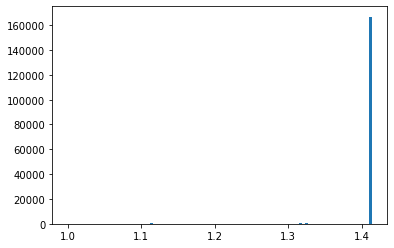

In [30]:
out = plt.hist(distances, bins=100)
plt.show()

In [42]:
max_distance = out[1][-2]
print (max_distance, out[1][0:2])

1.4100714267493644 [1.         1.00414214]


In [50]:
out[1][np.where(out[0] > 0)]

array([1.        , 1.11183766, 1.30651804, 1.31480231, 1.32308658,
       1.32722871, 1.41007143])

In [37]:
distances = distances [distances < max_distance]
print (len(distances), max(distances))

1562 1.3288492926150721


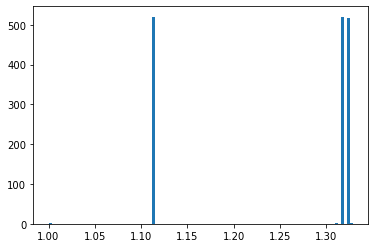

In [39]:
plt.hist(distances, bins=100)
plt.show()

In [43]:
%%time
clustering = DBSCAN(eps=1.1).fit(tfidf_data)

Wall time: 9min 30s


In [45]:
set(clustering.labels_)

{0}

In [46]:
%%time
clustering = DBSCAN(eps=1.15).fit(tfidf_data)
set(clustering.labels_)

Wall time: 9min 37s


{0}

In [ ]:
%%time
clustering = DBSCAN(eps=1.33).fit(tfidf_data)
set(clustering.labels_)